Name: Aria Wahyu Wicaksono

# Content-Based Filtering and Collaborative Filtering for Lazada Indonesian Review

Recommend top 5 items for user

## 1. Data Loading

In [2]:
!sudo pip install -q imbalanced-learn

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lazada-indonesian-reviews/categories.txt
/kaggle/input/lazada-indonesian-reviews/20191002-items.csv
/kaggle/input/lazada-indonesian-reviews/20191002-reviews.csv


In [3]:
df_items = pd.read_csv('/kaggle/input/lazada-indonesian-reviews/20191002-items.csv')
df_users = pd.read_csv("/kaggle/input/lazada-indonesian-reviews/20191002-reviews.csv")

## 2. Data Understanding
### 2.1. Missing and Duplicate Value

Remove duplicate itemID on `df_items`, user name on `df_users`, remove guest account (Lazada Customer and Lazada Guest), and remove any NaN values on itemID, user name, and user rating.

In [4]:
df_items = df_items.drop_duplicates(subset="itemId", keep='first')
df_items.head()

,itemId,category,name,brandName,url,price,averageRating,totalReviews,retrievedDate
0,100002528,beli-harddisk-eksternal,"TOSHIBA Smart HD LED TV 32"" - 32L5650VJ Free B...",Toshiba,https://www.lazada.co.id/products/toshiba-smar...,2499000,4,8,2019-10-02
1,100003785,beli-harddisk-eksternal,"TOSHIBA Full HD Smart LED TV 40"" - 40L5650VJ -...",Toshiba,https://www.lazada.co.id/products/toshiba-full...,3788000,3,3,2019-10-02
2,100004132,beli-harddisk-eksternal,Samsung 40 Inch Full HD Flat LED Digital TV 4...,LG,https://www.lazada.co.id/products/samsung-40-i...,3850000,3,2,2019-10-02
3,100004505,beli-harddisk-eksternal,"Sharp HD LED TV 24"" - LC-24LE175I - Hitam",Sharp,https://www.lazada.co.id/products/sharp-hd-led...,1275000,3,11,2019-10-02
4,100005037,beli-harddisk-eksternal,Lenovo Ideapad 130-15AST LAPTOP MULTIMEDIA I A...,Lenovo,https://www.lazada.co.id/products/lenovo-ideap...,3984100,5,1,2019-10-02


In [5]:
df_items.shape

(4422, 9)

In [6]:
df_users['old_name'] = df_users['name']
df_users['name'] = df_users['name'].str.lower().str.replace(".", "", regex=False).str.strip()
df_users = df_users.drop(df_users[df_users['name'] == "lazada customer"].index)
df_users = df_users.drop(df_users[df_users['name'] == "lazada guest"].index)

In [7]:
df_users = df_users.dropna(how='any', subset=["itemId", "name", "rating"])

In [8]:
df_users.head()

,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate,old_name
0,100002528,beli-harddisk-eksternal,kamal u,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,09 Apr 2019,androidApp,2019-10-02,Kamal U.
1,100002528,beli-harddisk-eksternal,yofanca m,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24 Sep 2017,androidApp,2019-10-02,yofanca m.
4,100002528,beli-harddisk-eksternal,yosep m,5,NaN,NaN,NaN,0,0,0,True,16.01,17 Agu 2018,androidApp,2019-10-02,Yosep M.
5,100002528,beli-harddisk-eksternal,deden,5,NaN,NaN,NaN,0,0,0,True,16.01,02 Nov 2017,androidApp,2019-10-02,Deden
6,100002528,beli-harddisk-eksternal,yeana,5,NaN,NaN,NaN,0,0,0,True,13.01,25 Sep 2017,mobile,2019-10-02,Yeana


In [9]:
df_users.shape

(153593, 16)

In [10]:
df_users[["itemId", "name", "rating"]].head()

,itemId,name,rating
0,100002528,kamal u,5
1,100002528,yofanca m,4
4,100002528,yosep m,5
5,100002528,deden,5
6,100002528,yeana,5


### 2.2. Univariate Analysis for Ratings' Column

In [11]:
df_users['rating'].describe()

count    153593.000000
mean          4.610607
std           0.982215
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

It looks that most ratings are 5 stars. To visualize it, plot histogram of rating's distribution.

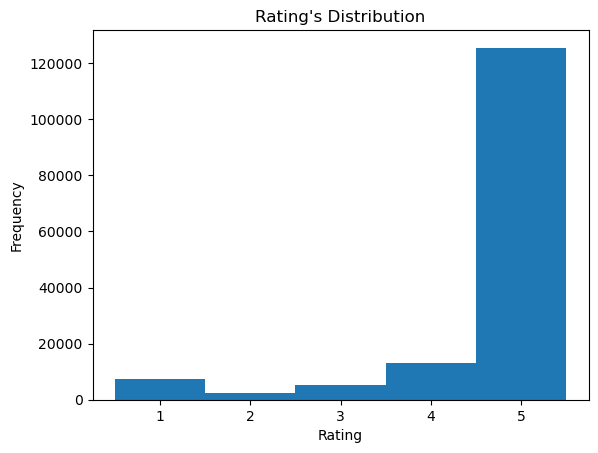

In [12]:
plt.hist(df_users['rating'], bins=range(1,7), align='left')
plt.title("Rating's Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(range(1,6))
plt.show()

In [13]:
print("Actual shape:", df_users.shape[0])

Actual shape: 153593


## 3. Data Preparation

### 3.1. User ID and Item ID Encoding

In [14]:
item_encoder = {x: i for i, x in enumerate(df_items['itemId'].unique().tolist())}
user_encoder = {x: i for i, x in enumerate(df_users['name'].unique().tolist())}
item_decoder = {i: x for i, x in enumerate(df_items['itemId'].unique().tolist())}
user_decoder = {i: x for i, x in enumerate(df_users['name'].unique().tolist())}
item_id_to_name = {df_items.loc[i, 'itemId']: df_items.loc[i, 'name'] for i in df_items.index}

In [15]:
df_users['item'] = df_users['itemId'].map(item_encoder)
df_users['user'] = df_users['name'].map(user_encoder)

In [16]:
df_users[['item', 'user']].head(10)

,item,user
0,0,0
1,0,1
4,0,2
5,0,3
6,0,4
7,0,5
8,1,6
9,1,7
10,1,8
12,2,9


### 3.2. Data Splitting and Balancing

In [17]:
X = df_users[['user', 'item']].values
y = df_users['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=83)
y_train.value_counts()

5    100397
4     10526
1      5796
3      4211
2      1944
Name: rating, dtype: int64

100,397 out of 153,593 are labelled as 5 stars. Use SMOTE-ENN sampling (combination of oversampling and undersampling) to balance the distribution.

In [18]:
oversample = SMOTEENN(random_state=83)
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

1    73007
2    65618
3    60688
4    57104
5    54928
Name: rating, dtype: int64

In [19]:
X_train

array([[19442,  2043],
       [ 9771,  1149],
       [ 5682,  2746],
       ...,
       [18115,  3570],
       [  351,  1757],
       [ 1132,  1177]])

In [20]:
y_train

0         1
1         1
2         1
3         1
4         1
         ..
311340    5
311341    5
311342    5
311343    5
311344    5
Name: rating, Length: 311345, dtype: int64

### 3.3. Data Normalization

Normalize ratings into (0, 1) because the model will be using sigmoid function for the output.

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(np.reshape(y_train.values, (-1,1)))
y_val_scaled = scaler.transform(np.reshape(y_val.values, (-1,1)))

In [22]:
y_val_scaled

array([[1.  ],
       [0.75],
       [1.  ],
       ...,
       [0.75],
       [1.  ],
       [1.  ]])

### 3.4. Text Preprocessing

In [23]:
stop_words = set(nltk.corpus.stopwords.words('indonesian'))

def preprocess_text(text, stop_words=stop_words):
    text = text.lower()
    text = re.sub(r'[^\w\s]|_', "", text)
    text = text.strip()
    text = re.sub(r'\s+', " ", text)
    text =  ' '.join(w for w in text.split() if w not in stop_words)
    return text

df_items['clean_name'] = df_items['name'].apply(preprocess_text)

In [24]:
df_items[['name', 'clean_name']].head()

,name,clean_name
0,"TOSHIBA Smart HD LED TV 32"" - 32L5650VJ Free B...",toshiba smart hd led tv 32 32l5650vj free brac...
1,"TOSHIBA Full HD Smart LED TV 40"" - 40L5650VJ -...",toshiba full hd smart led tv 40 40l5650vj hita...
2,Samsung 40 Inch Full HD Flat LED Digital TV 4...,samsung 40 inch full hd flat led digital tv 40...
3,"Sharp HD LED TV 24"" - LC-24LE175I - Hitam",sharp hd led tv 24 lc24le175i hitam
4,Lenovo Ideapad 130-15AST LAPTOP MULTIMEDIA I A...,lenovo ideapad 13015ast laptop multimedia i am...


## 4. Modeling

### 4.1. Content Based Filtering

In [25]:
tfid = TfidfVectorizer()
tfid.fit(df_items['clean_name'])
tfidf_matrix = tfid.fit_transform(df_items['clean_name'])
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [26]:
def recommendations(name, N=10, df=df_items, cos_sim = cos_sim):
    
    recommendation = []
    idx = df[df['clean_name'] == name].index[0]
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)
    top_N_indexes = list(score_series.iloc[1:N+1].index)
    for i in top_N_indexes:
        recommendation.append(list(df['name'])[i])
    return score_series.iloc[1:N+1], recommendation

### 4.2. Collaborative Filtering

Modified from: [Collaborative Filtering for Movie Recommendations by Siddhartaha Banerjee](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)

In [27]:
class Recommender(tf.keras.Model):

    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer = 'random_normal',
            embeddings_regularizer = tf.keras.regularizers.l2(1e-5)
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1)
        self.item_embedding = tf.keras.layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer = 'random_normal',
            embeddings_regularizer = tf.keras.regularizers.l2(1e-5)
        )
        self.item_bias = tf.keras.layers.Embedding(num_items, 1) 
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        user_bias = self.user_bias(inputs[:, 0]) 
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2) 
        x = dot_user_item + user_bias + item_bias
        return tf.nn.sigmoid(x)

For the sake of execution time, I limit the embedding size to 64.

In [28]:
num_users = len(user_encoder)
num_items = len(item_encoder)
model = Recommender(num_users, num_items, 64)
 
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                            restore_best_weights=True, patience=5)

In [29]:
history = model.fit(
    x = X_train,
    y = y_train_scaled,
    batch_size = 64,
    epochs = 100,
    callbacks=[callback],
    validation_data = (X_val, y_val_scaled)
)

Epoch 1/100
4865/4865 [==============================] - 137s 28ms/step - loss: 0.6560 - root_mean_squared_error: 0.3225 - mae: 0.2732 - val_loss: 0.5762 - val_root_mean_squared_error: 0.3992 - val_mae: 0.3740
Epoch 2/100
4865/4865 [==============================] - 139s 29ms/step - loss: 0.6030 - root_mean_squared_error: 0.2796 - mae: 0.2265 - val_loss: 0.5330 - val_root_mean_squared_error: 0.3755 - val_mae: 0.3397
Epoch 3/100
4865/4865 [==============================] - 137s 28ms/step - loss: 0.5719 - root_mean_squared_error: 0.2564 - mae: 0.2004 - val_loss: 0.5105 - val_root_mean_squared_error: 0.3641 - val_mae: 0.3211
Epoch 4/100
4865/4865 [==============================] - 134s 27ms/step - loss: 0.5526 - root_mean_squared_error: 0.2420 - mae: 0.1839 - val_loss: 0.5006 - val_root_mean_squared_error: 0.3595 - val_mae: 0.3110
Epoch 5/100
4865/4865 [==============================] - 128s 26ms/step - loss: 0.5395 - root_mean_squared_error: 0.2324 - mae: 0.1727 - val_loss: 0.4871 - val_

## 5. Result and Evaluation

### 5.1. Content-Based Filtering

In [30]:
test_item = df_items.sample(1, random_state=83).iloc[0]
print("Items similar to", test_item['name'], ":")
print("=====" * 20)
similarities, recommendations_result = recommendations(test_item['clean_name'], N=5)
for i, recommendation in enumerate(recommendations_result):
    print(f"{i+1}. {recommendation}")

Items similar to Seagate Expansion Portable Drive 2TB 2.5" USB 3.0 HDD/ Hardisk/ Harddisk External/ Hard Drive :
1. Seagate Expansion Portable 2TB 2.5" USB 3.0 HDD/ Hardisk/ Harddisk External/ Hard Drive - Hitam
2. Seagate Expansion Portable Drive 1TB 2.5" USB 3.0 HDD/ Hardisk/ Harddisk External/ Hard Drive
3. Seagate Expansion Portable Drive 500GB 2.5" USB 3.0 HDD/ Hardisk/ Harddisk External/ Hard Drive
4. Seagate Expansion Portable Drive 4TB 2.5" USB 3.0 HDD/ Hardisk/ Harddisk External/ Hard Drive
5. Seagate Expansion Portable 1TB 2.5" USB 3.0 HDD/ Hardisk/ Harddisk External/ Hard Drive - Hitam


In [31]:
print("Top 5 cosine similarities:")
print("=====" * 10)
for i, similarity in enumerate(similarities):
    print(f"{i+1}. {similarity}")

Top 5 cosine similarities:
1. 0.9549566791215383
2. 0.9277813552501742
3. 0.907377269924378
4. 0.888086706028696
5. 0.8801537980668251


### 5.2. Collaborative Filtering

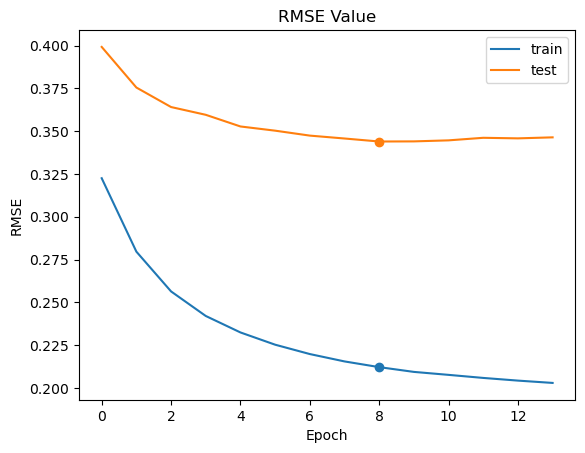

In [32]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.scatter(callback.best_epoch, history.history['root_mean_squared_error'][callback.best_epoch])
plt.scatter(callback.best_epoch, history.history['val_root_mean_squared_error'][callback.best_epoch])
plt.title('RMSE Value')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

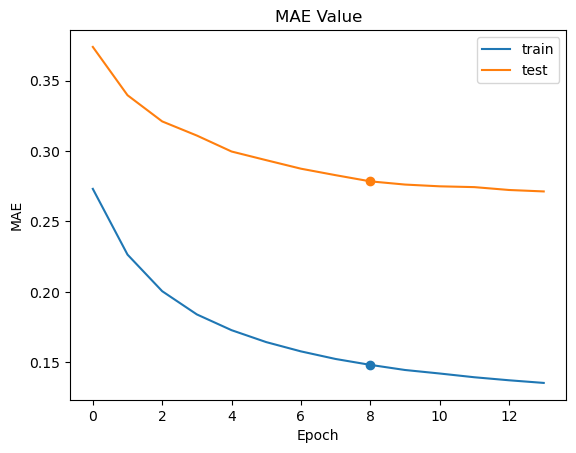

In [33]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.scatter(callback.best_epoch, history.history['mae'][callback.best_epoch])
plt.scatter(callback.best_epoch, history.history['val_mae'][callback.best_epoch])
plt.title('MAE Value')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [34]:
print("RMSE from model's rating:")
print("Train:", history.history['root_mean_squared_error'][callback.best_epoch])
print("Test:", history.history['val_root_mean_squared_error'][callback.best_epoch])

RMSE from model's rating:
Train: 0.21216611564159393
Test: 0.3439439535140991


In [35]:
print("MAE from model's rating:")
print("Train:", history.history['mae'][callback.best_epoch])
print("Test:", history.history['val_mae'][callback.best_epoch])

MAE from model's rating:
Train: 0.1480945646762848
Test: 0.2785094380378723


In [36]:
test_name = df_users['name'].sample(1, random_state=1).to_numpy()[0]
test_raw_name = df_users[df_users['name'] == test_name]['old_name'].iloc[0]
test_user_id = df_users[df_users['name'] == test_name]['user'].iloc[0]

In [37]:
item_id_bought = df_users[df_users['name'] == test_name]['itemId'].unique()
print("Item bought by", test_raw_name)
print("=====" * 20)
print(*["-  "+item_id_to_name[x] for x in item_id_bought], sep='\n')

Item bought by Denny
-  ORICO 2139U3 Enclosure HDD/SSD 2.5" USB3.0 - Transparent Garansi Resmi 1 Tahun
-  SanDisk CZ50 Cruzer Blade USB 2.0 - 32 GB - Hitam
-  WD My Passport New Design 1TB/2.5Inch/USB3.0 - Merah + Free Pouch + Pen
-  WD My Passport New Design 1TB/2.5Inch/USB3.0 - Putih + Free Pouch + Pen
-  Dell Inspiron 3180 RESMI ( AMD A9 - 9420  4GB DDR4  500GB  WIN10  11 HD )
-  [GRATIS ONGKIR] Samsung HD TV 24 inch (model: 24H4150 Series 4)
-  SanDisk Flashdisk Cruzer Blade CZ50 - 16GB
-  EsoGoal Pengisian Station Tas Hardisk Eksternal Dual Bay HDD Docking Station, External Hard Drive Base Box SATA to USB 3.0 Adapter for 2.5 3.5 HDD SSD External Hard Drive Disk Case with UASP Protocol 2 x 8TB Supported
-  [GRATIS ONGKIR] Samsung Full HD TV 40 inch (Model 40N5000)
-  Asus X441MA-GA011T - Intel® Celeron® N4000 - RAM 4GB - 1Tb - 14" - W10 - Black - Laptop Murah (Gratis Tas) - Bergaransi
-  Special Promo!! Case harddisk Hard Case Shockproof Tas Hardisk / Powerbank  Softcase Tahan Bant

In [38]:
item_id_not_bought = df_items[~df_items['itemId'].isin(item_id_bought)]['itemId']
item_not_bought = [[item_encoder.get(x)] for x in item_id_not_bought]
arr = np.hstack(([[test_user_id]] * len(item_not_bought), item_not_bought))
ratings = model.predict(arr).flatten()

138/138 [==============================] - 0s 1ms/step


In [39]:
recommended_items_id = [item_decoder.get(x) for x in ratings.argsort()[-5:]]
recommended_items = [item_id_to_name[x] for x in recommended_items_id]
print("Recommendation for ",test_raw_name)
print("=====" * 20)
recommendation = [f"{i+1}. {x}\n" for i, x in enumerate(recommended_items)]
print(*recommendation, sep='\n')

Recommendation for  Denny
1. Lenovo Thinkpad 11E-5V00 Quad Core N2940 - 4GB - 500GB - Windows 10 PRO

2. Acer E5-476G-56VN - Intel core i5-8250U - 4GB - 1TB -Nvidia geforce Mx150 - 14  - ODD - W10 - Silver - Laptop Murah (Gratis Tas) - Bergaransi

3. Samsung BAR Plus USB 3.1 Flash Drive 32GB - Hitam

4. flashdisk hp 32gb / flasdisk hp 32gb / flash disk hp 32gb/usb

5. Flashdisk 16 GB Kingston Flashdisk Data Traveler [BMS 1212]



In [40]:
predicted_ratings = scaler.inverse_transform(np.reshape(np.sort(ratings)[-5:], (-1,1)))
print("Rating for each item:")
for i, rating in enumerate(predicted_ratings.flatten()):
    print(i+1, ": ", rating)

Rating for each item:
1 :  4.895483
2 :  4.899954
3 :  4.9054146
4 :  4.927363
5 :  4.9499083
